In [12]:
import gym_duckietown
import cv2
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

from scipy import spatial

import utils
from utils import get_trajectory, get_position, my_odometry

import math

In [13]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [14]:
plt.rcParams['figure.figsize'] = [7, 7]

In [15]:
env = Simulator("ETU_autolab_track",
    full_transparency=True,
    domain_rand=False,
    seed=42,
    max_steps=float("inf"),
)

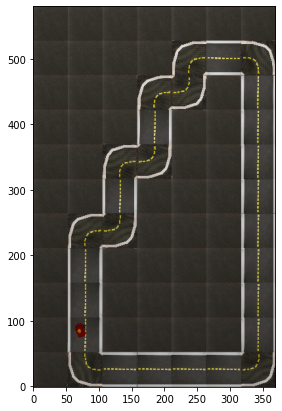

In [16]:
plt.imshow(utils.get_top_view(env), origin="lower")

In [18]:
env.reset()
top_view = utils.get_top_view(env)
# top_view = get_top_view(env)

img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

lower_yellow = np.array([20,100,150])
upper_yellow = np.array([30,255,255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask = cv2.bitwise_and(gray, mask_yellow)

kernel = np.ones((4, 4), np.uint8)
eroded = cv2.erode(mask, kernel) 

low_threshold = 89
high_threshold = 80
edges = cv2.Canny(mask, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 3  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10  # minimum number of pixels making up a line
max_line_gap = 50  # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

_points = lines.reshape(-1, 2)

x, y = _points.T
x, y = utils.image_to_tile_coordinates(x, y, env)

In [19]:
tree = spatial.KDTree(_points)
point = _points[0]
pts = _points[1:]
sortedxy = [point]
for i in range(len(x)-1):
    tree = spatial.KDTree(pts)
    dist, idx = tree.query([*point], k=1)
    point = pts[idx]
    pts = np.delete(pts, idx, 0)
    sortedxy.append(point)

In [20]:
x_srt, y_srt = np.array(sortedxy).T

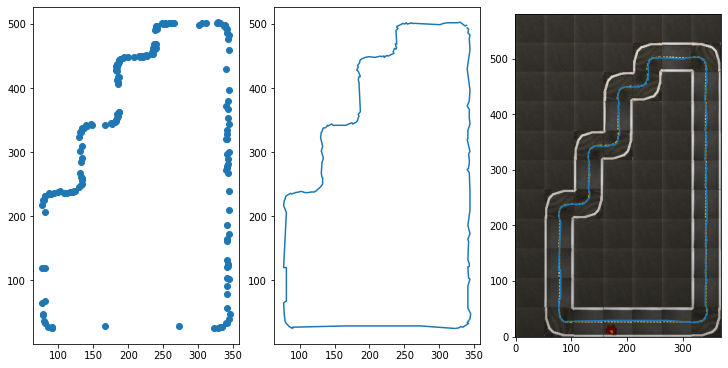

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("ABC")
ax_dict["A"].scatter(x_srt,y_srt)
ax_dict["B"].plot(x_srt,y_srt)
ax_dict["C"].plot(x_srt,y_srt)
utils.show_on_map_array(env, np.array([x_srt,y_srt]).T, fig=ax_dict["C"])